In [ ]:
!nvidia-smi

Thu Mar 18 12:32:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00111447days (96.29sec)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [2]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain3.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [6]:
!unzip -nq "cortical_ImagenetTrain3.zip"
!unzip -nq "cortical_ImagenetTest2.zip"

In [7]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list


In [8]:
rootpathTrain ='cortical_ImagenetTrain3/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [9]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [10]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [11]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [12]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [13]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [14]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [15]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [16]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


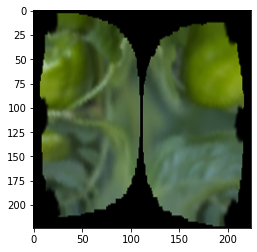

In [17]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [18]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [19]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [20]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [21]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 40

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [22]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [23]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [24]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

### Training & Test for model

In [25]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [27]:
LOAD_STATE = True
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "05_3_mobilenet"

if LOAD_STATE:
    stats=[];
    folder_name = "mobilenet"
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model = models.mobilenet_v2()
    best_model.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "mobilenet", DEBUG)

Epoch 1/40
-------------



83814
train Loss: 0.0404 Acc: 59.2041



23432
val Loss: 0.0330 Acc: 66.2071
-------------
Epoch 2/40
-------------



98519
train Loss: 0.0297 Acc: 69.5913



25742
val Loss: 0.0266 Acc: 72.7340
-------------
Epoch 3/40
-------------



104269
train Loss: 0.0257 Acc: 73.6529



25328
val Loss: 0.0281 Acc: 71.5642
-------------
Epoch 4/40
-------------



108004
train Loss: 0.0229 Acc: 76.2913



26964
val Loss: 0.0228 Acc: 76.1867
-------------
Epoch 5/40
-------------



111071
train Loss: 0.0207 Acc: 78.4577



27489
val Loss: 0.0217 Acc: 77.6701
-------------
Epoch 6/40
-------------



113917
train Loss: 0.0187 Acc: 80.4680



28130
val Loss: 0.0199 Acc: 79.4812
-------------
Epoch 7/40
-------------



116100
train Loss: 0.0172 Acc: 82.0101



27929
val Loss: 0.0205 Acc: 78.9133
-------------
Epoch 8/40
-------------



117997
train Loss: 0.0158 Acc: 83.3501



28576
val Loss: 0.0188 Acc: 80.7414
-------------
Epoch 9/40
-------------



119991
train Loss: 0.0145 Acc: 84.7586



28720
val Loss: 0.0185 Acc: 81.1483
-------------
Epoch 10/40
-------------



121196
train Loss: 0.0135 Acc: 85.6097



29305
val Loss: 0.0171 Acc: 82.8012
-------------
Epoch 11/40
-------------



122888
train Loss: 0.0124 Acc: 86.8049



28880
val Loss: 0.0180 Acc: 81.6004
-------------
Epoch 12/40
-------------



124387
train Loss: 0.0114 Acc: 87.8638



29513
val Loss: 0.0170 Acc: 83.3889
-------------
Epoch 13/40
-------------



125705
train Loss: 0.0105 Acc: 88.7948



29179
val Loss: 0.0176 Acc: 82.4452
-------------
Epoch 14/40
-------------



126789
train Loss: 0.0097 Acc: 89.5605



29359
val Loss: 0.0176 Acc: 82.9538
-------------
Epoch 15/40
-------------



127798
train Loss: 0.0090 Acc: 90.2732



29793
val Loss: 0.0164 Acc: 84.1800
-------------
Epoch 16/40
-------------



128805
train Loss: 0.0084 Acc: 90.9845



29769
val Loss: 0.0163 Acc: 84.1122
-------------
Epoch 17/40
-------------



129752
train Loss: 0.0078 Acc: 91.6535



29535
val Loss: 0.0170 Acc: 83.4511
-------------
Epoch 18/40
-------------



130479
train Loss: 0.0072 Acc: 92.1670



30004
val Loss: 0.0160 Acc: 84.7762
-------------
Epoch 19/40
-------------



131268
train Loss: 0.0067 Acc: 92.7243



30216
val Loss: 0.0155 Acc: 85.3752
-------------
Epoch 20/40
-------------



132009
train Loss: 0.0063 Acc: 93.2478



30179
val Loss: 0.0162 Acc: 85.2707
-------------
Epoch 21/40
-------------



132717
train Loss: 0.0058 Acc: 93.7479



30377
val Loss: 0.0158 Acc: 85.8301
-------------
Epoch 22/40
-------------



133156
train Loss: 0.0054 Acc: 94.0580



30222
val Loss: 0.0160 Acc: 85.3922
-------------
Epoch 23/40
-------------



133982
train Loss: 0.0049 Acc: 94.6414



30425
val Loss: 0.0157 Acc: 85.9658
-------------
Epoch 24/40
-------------



134330
train Loss: 0.0047 Acc: 94.8873



30452
val Loss: 0.0156 Acc: 86.0420
-------------
Epoch 25/40
-------------



134786
train Loss: 0.0044 Acc: 95.2094



30156
val Loss: 0.0172 Acc: 85.2057
-------------
Epoch 26/40
-------------



135186
train Loss: 0.0042 Acc: 95.4919



30768
val Loss: 0.0150 Acc: 86.9349
-------------
Epoch 27/40
-------------



135563
train Loss: 0.0039 Acc: 95.7582



30664
val Loss: 0.0161 Acc: 86.6410
-------------
Epoch 28/40
-------------



135914
train Loss: 0.0036 Acc: 96.0062



30890
val Loss: 0.0150 Acc: 87.2796
-------------
Epoch 29/40
-------------



136191
train Loss: 0.0035 Acc: 96.2018



30782
val Loss: 0.0153 Acc: 86.9745
-------------
Epoch 30/40
-------------



136407
train Loss: 0.0033 Acc: 96.3544



30892
val Loss: 0.0149 Acc: 87.2853
-------------
Epoch 31/40
-------------



136859
train Loss: 0.0031 Acc: 96.6737



30840
val Loss: 0.0155 Acc: 87.1383
-------------
Epoch 32/40
-------------



137098
train Loss: 0.0029 Acc: 96.8425



30797
val Loss: 0.0161 Acc: 87.0168
-------------
Epoch 33/40
-------------



137237
train Loss: 0.0028 Acc: 96.9407



30954
val Loss: 0.0153 Acc: 87.4604
-------------
Epoch 34/40
-------------



137462
train Loss: 0.0026 Acc: 97.0996



31222
val Loss: 0.0142 Acc: 88.2177
-------------
Epoch 35/40
-------------



137717
train Loss: 0.0025 Acc: 97.2798



30975
val Loss: 0.0151 Acc: 87.5198
-------------
Epoch 36/40
-------------



137856
train Loss: 0.0024 Acc: 97.3779



30979
val Loss: 0.0160 Acc: 87.5311
-------------
Epoch 37/40
-------------



137987
train Loss: 0.0024 Acc: 97.4705



31053
val Loss: 0.0148 Acc: 87.7402
-------------
Epoch 38/40
-------------



138175
train Loss: 0.0022 Acc: 97.6033



30867
val Loss: 0.0157 Acc: 87.2146
-------------
Epoch 39/40
-------------



138381
train Loss: 0.0021 Acc: 97.7488



31043
val Loss: 0.0156 Acc: 87.7119
-------------
Epoch 40/40
-------------



138367
train Loss: 0.0020 Acc: 97.7389



31185
val Loss: 0.0151 Acc: 88.1131
-------------
Lowest training loss 0.002040316807182153
Lowest validation loss 0.014245455307995947
Highest training accuracy 97.74878503616637
Highest validation accuracy 88.21767631103074
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Loss _.png05_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Accuracy _.png05_3_mobilenet_Accuracy _.png


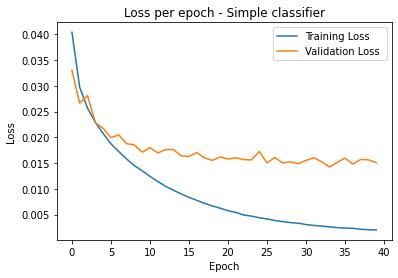

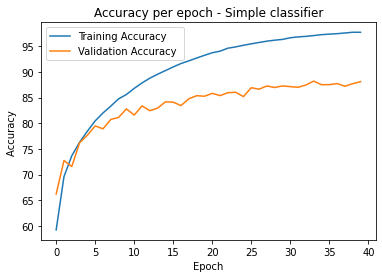

In [28]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.6101 
Testing Accuracy: 1709/2000 (85.45%)
apple Class Accuracy: 79/100 (79.00%)
banana Class Accuracy: 91/100 (91.00%)
bear Class Accuracy: 85/100 (85.00%)
bell_pepper Class Accuracy: 93/100 (93.00%)
bird Class Accuracy: 88/100 (88.00%)
broccoli Class Accuracy: 91/100 (91.00%)
cat Class Accuracy: 86/100 (86.00%)
cauliflower Class Accuracy: 80/100 (80.00%)
cow Class Accuracy: 73/100 (73.00%)
dog Class Accuracy: 71/100 (71.00%)
elephant Class Accuracy: 90/100 (90.00%)
fox Class Accuracy: 89/100 (89.00%)
goat Class Accuracy: 68/100 (68.00%)
horse Class Accuracy: 81/100 (81.00%)
mashed_potato Class Accuracy: 87/100 (87.00%)
orange Class Accuracy: 87/100 (87.00%)
pineapple Class Accuracy: 90/100 (90.00%)
pomegranate Class Accuracy: 94/100 (94.00%)
tomato Class Accuracy: 93/100 (93.00%)
zebra Class Accuracy: 93/100 (93.00%)
Classifier has Acc=0.855 P=0.855 R=0.856 F1=0.854
               precision    recall  f1-score   support

        apple       0.90      0.79      0.84     

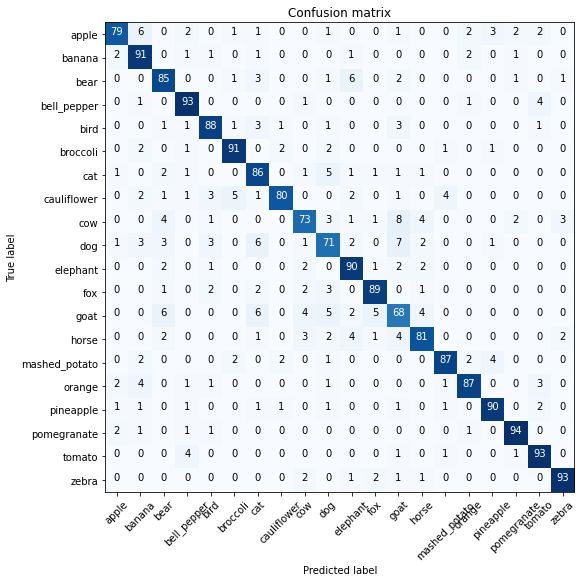

In [29]:
result = test_model(best_model, criterion, name)

/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Loss _.png05_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Accuracy _.png05_3_mobilenet_Accuracy _.png


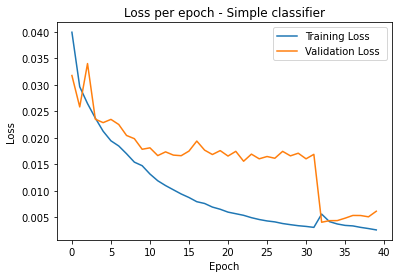

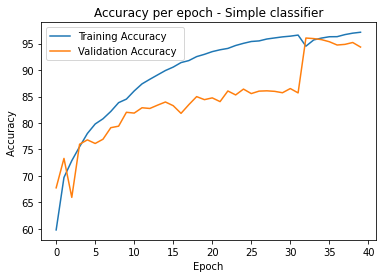

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.2285 
Testing Accuracy: 1143/2000 (57.15%)
apple Class Accuracy: 53/100 (53.00%)
banana Class Accuracy: 60/100 (60.00%)
bear Class Accuracy: 71/100 (71.00%)
bell_pepper Class Accuracy: 61/100 (61.00%)
bird Class Accuracy: 48/100 (48.00%)
broccoli Class Accuracy: 70/100 (70.00%)
cat Class Accuracy: 39/100 (39.00%)
cauliflower Class Accuracy: 49/100 (49.00%)
cow Class Accuracy: 29/100 (29.00%)
dog Class Accuracy: 41/100 (41.00%)
elephant Class Accuracy: 63/100 (63.00%)
fox Class Accuracy: 63/100 (63.00%)
goat Class Accuracy: 29/100 (29.00%)
horse Class Accuracy: 46/100 (46.00%)
mashed_potato Class Accuracy: 62/100 (62.00%)
orange Class Accuracy: 73/100 (73.00%)
pineapple Class Accuracy: 63/100 (63.00%)
pomegranate Class Accuracy: 73/100 (73.00%)
tomato Class Accuracy: 66/100 (66.00%)
zebra Class Accuracy: 84/100 (84.00%)
Classifier has Acc=0.572 P=0.572 R=0.579 F1=0.569
               precision    recall  f1-score   support

        apple       0.67      0.53      0.59     

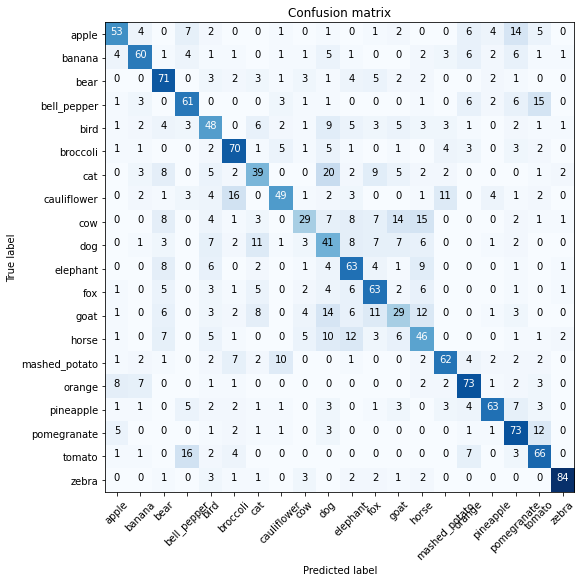

In [ ]:
result = test_model(best_model, criterion, name)